## Τεχνητά Νευρωνικά Δίκτυα και Μηχανική Μάθηση: Χειμ. Εξάμ. 2019-2020.



### [Γεωργία Ανδριοσοπούλου](https://github.com/GeorgiaAndr22) (03400042) - ΕΔΕΜΜ.

### [Ζωγραφάκης Δημήτριος](https://github.com/dimzog) (03400050) - ΕΔΕΜΜ.

### [Ανδρέας Μαστακούρης](https://github.com/AndreasMastakouris) (03400062) - ΕΔΕΜΜ.



### Η παρούσα εξαμηνιαία εργασία εξετάζει το Σύνολο Δεδομένων: "[What's Cooking?](https://www.kaggle.com/c/whats-cooking/data)".

## Δομή Πρότζεκτ


```
~/Machine-Learning_03400042_03400050_03400062/
│
└──data
│  └──test.json
│  └──train.json
│
│  Assignment.pdf             # Εκφώνηση Εργασίας
│  Documentation.pdf          # Παρουσίαση
│
│  whatscooking.ipnyb         # Κώδικας της εργασίας
│  whatscooking.html          # Jupyter σε html
│
│  README.md                  # Αρχική σελίδα του repo
│  requirements.txt           # Βιβλιοθήκες που χρησιμοποίηθηκαν

```

Βασικά imports

In [1]:
!pip install -r requirements.txt

import time
from time import time

import re
import pickle

import pandas as pd
import numpy as np

np.random.seed(42)

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')

# Plotting
import matplotlib.pyplot as plt

# Seaborn configuration
import seaborn as sns
sns.set(rc={'figure.figsize':(11.5, 8.3)}, style="darkgrid", font_scale=1.5)

import networkx as nx

# scikit imports
from sklearn import tree
from sklearn import metrics
from sklearn.svm import SVC
from collections import Counter
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dimzog\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dimzog\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 1. Προεπεξεργασία Δεδομένων

* Ανάγνωση Αρχείων από μορφή json.

* Αφαίρεση συνταγών με λιγότερα υλικά από 2.

* Αλλαγή γραμματοσείρας από κεφαλαία γράμματα σε μικρά.

* Αφαιρούνται σύμβολα, αριθμοί από τις συνταγές και προστίθενται ως νέα στήλη "seperated_ingredients",.

In [2]:
train_df = pd.read_json("data/train.json",  dtype={"id": "int64", "cuisine": "str", "ingredients": "str"})
train_df = train_df[train_df.ingredients.str.len() > 1]

# Convert to lowercase
train_df["seperated_ingredients"] = train_df.ingredients.str.lower()

# Remove punctuation
reg = re.compile("[^\w\s\,]|\d")
train_df.seperated_ingredients.replace(reg, "", inplace=True)

train_df.head()

,id,cuisine,ingredients,seperated_ingredients
0,10259,greek,"['romaine lettuce', 'black olives', 'grape tom...","romaine lettuce, black olives, grape tomatoes,..."
1,25693,southern_us,"['plain flour', 'ground pepper', 'salt', 'toma...","plain flour, ground pepper, salt, tomatoes, gr..."
2,20130,filipino,"['eggs', 'pepper', 'salt', 'mayonaise', 'cooki...","eggs, pepper, salt, mayonaise, cooking oil, gr..."
3,22213,indian,"['water', 'vegetable oil', 'wheat', 'salt']","water, vegetable oil, wheat, salt"
4,13162,indian,"['black pepper', 'shallots', 'cornflour', 'cay...","black pepper, shallots, cornflour, cayenne pep..."


### Λημματοποίηση

In [3]:
lemmatizer = WordNetLemmatizer()

# Tokenize and then lemmatize every word in ingredients
train_df["seperated_ingredients"] = train_df.seperated_ingredients.apply(
                  lambda x: " ".join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(x)]))


# Remove annoying whitespace added before and after ','
reg = re.compile(" , ")
train_df.seperated_ingredients.replace(reg, ",", inplace=True)

train_df.head()

,id,cuisine,ingredients,seperated_ingredients
0,10259,greek,"['romaine lettuce', 'black olives', 'grape tom...","romaine lettuce,black olive,grape tomato,garli..."
1,25693,southern_us,"['plain flour', 'ground pepper', 'salt', 'toma...","plain flour,ground pepper,salt,tomato,ground b..."
2,20130,filipino,"['eggs', 'pepper', 'salt', 'mayonaise', 'cooki...","egg,pepper,salt,mayonaise,cooking oil,green ch..."
3,22213,indian,"['water', 'vegetable oil', 'wheat', 'salt']","water,vegetable oil,wheat,salt"
4,13162,indian,"['black pepper', 'shallots', 'cornflour', 'cay...","black pepper,shallot,cornflour,cayenne pepper,..."


### Έλεγχος για κενές Τιμές

In [4]:
# Total missing values
total = train_df.isnull().sum()

# Percent Missing
percent = (train_df.isnull().sum()/train_df.isnull().count()*100)

missing_train_data  = pd.concat([total, percent], axis=1, keys=["Total missing", "Percent missing"])

missing_train_data.head()

,Total missing,Percent missing
id,0,0.0
cuisine,0,0.0
ingredients,0,0.0
seperated_ingredients,0,0.0


In [5]:
unique = train_df.cuisine.unique()

print(f"{len(unique)} unique cousines, namely: {unique}")

20 unique cousines, namely: ['greek' 'southern_us' 'filipino' 'indian' 'jamaican' 'spanish' 'italian'
 'mexican' 'chinese' 'british' 'thai' 'vietnamese' 'cajun_creole'
 'brazilian' 'french' 'japanese' 'irish' 'korean' 'moroccan' 'russian']


### Δημιουργία Συνόλων Εκπαίδευσης και Τεστ (Αραιοί Πίνακες)

* Vectorize train_df.separated_ingredients --> create X_train_vectorized

* Encode train_df.cuisine with values --> y_transformed = labels (0,..,19)

* Train & Test split (from X_train_vectorized and y_transformed) --> 80%, 20%

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# TFIDF, convert to sparse matrices
vect = TfidfVectorizer(binary=True).fit(train_df["seperated_ingredients"].values)
X_train_vectorized = vect.transform(train_df["seperated_ingredients"].values)
X_train_vectorized = X_train_vectorized.astype("float")

encoder = LabelEncoder()
y_transformed = encoder.fit_transform(train_df.cuisine)

X_train, X_test, y_train, y_test = train_test_split(X_train_vectorized, y_transformed , train_size=0.80, random_state = 0)

print(f"Size of training data {X_train.shape[0]}, size of test data: {X_test.shape[0]}.")

Size of training data 31819, size of test data: 7955.


### Αντιστοιχία id με Κουζίνα

In [7]:
dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

{'brazilian': 0,
 'british': 1,
 'cajun_creole': 2,
 'chinese': 3,
 'filipino': 4,
 'french': 5,
 'greek': 6,
 'indian': 7,
 'irish': 8,
 'italian': 9,
 'jamaican': 10,
 'japanese': 11,
 'korean': 12,
 'mexican': 13,
 'moroccan': 14,
 'russian': 15,
 'southern_us': 16,
 'spanish': 17,
 'thai': 18,
 'vietnamese': 19}

# 2. Αναπαράσταση Γνώσης

## Συχνότερες Κουζίνες στο Σύνολο Δεδομένων

### Κατανομή Κουζινών (Ιστόγραμμα)

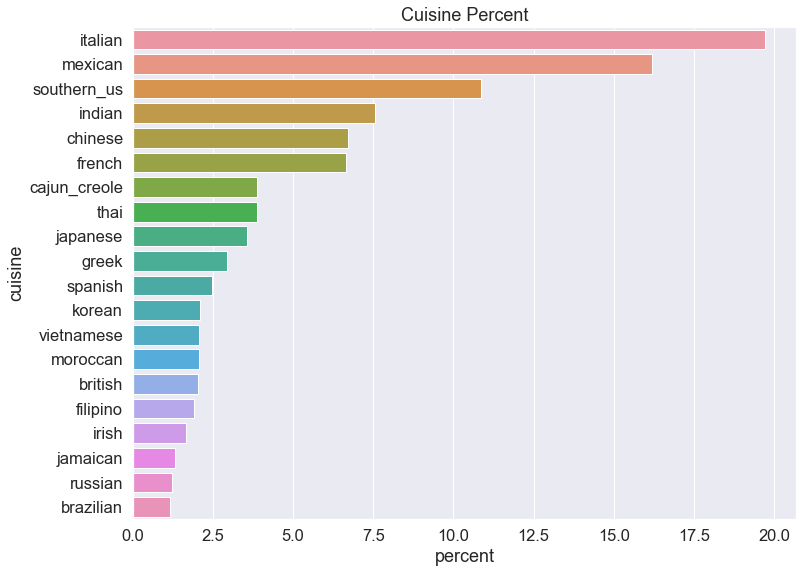

In [8]:
# Count total occurencies of each cuisine
vc = train_df["cuisine"].value_counts().reset_index(name="counts")

# Rename for better visuals
vc = vc.rename(columns = {"index": "cuisine"})

# Calculate percent for each cuisine
vc["percent"] = (vc.counts / vc.counts.sum()) * 100

# plot cuisines against counts
ax = sns.barplot(x=vc.percent, y=vc.cuisine)
ax.set_title("Cuisine Percent")

plt.tight_layout()
plt.show()

### Κατανομή Κουζινών (Πίτα)

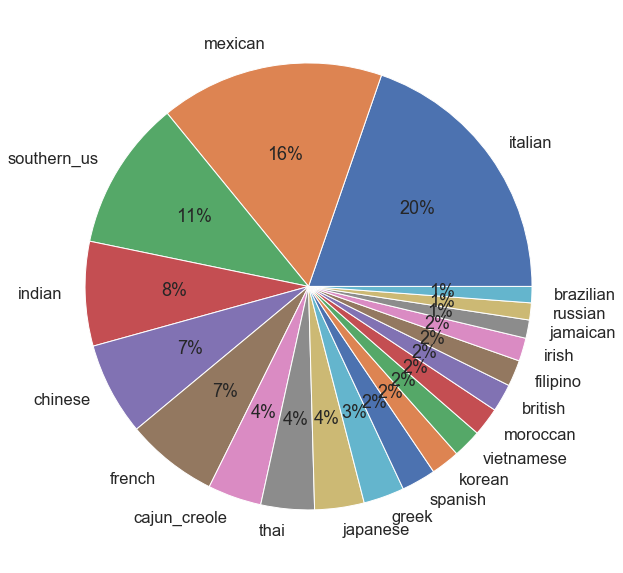

In [9]:
# Pie plot
ax = vc.plot(kind="pie", y="counts", legend=False, autopct="%1.f%%", labels=vc.cuisine, label="big")

# Remove annoying y label
ax.set_ylabel("")

plt.tight_layout()
plt.show()

### Πλήθος Υλικών ανά Συνταγή (Boxplot)

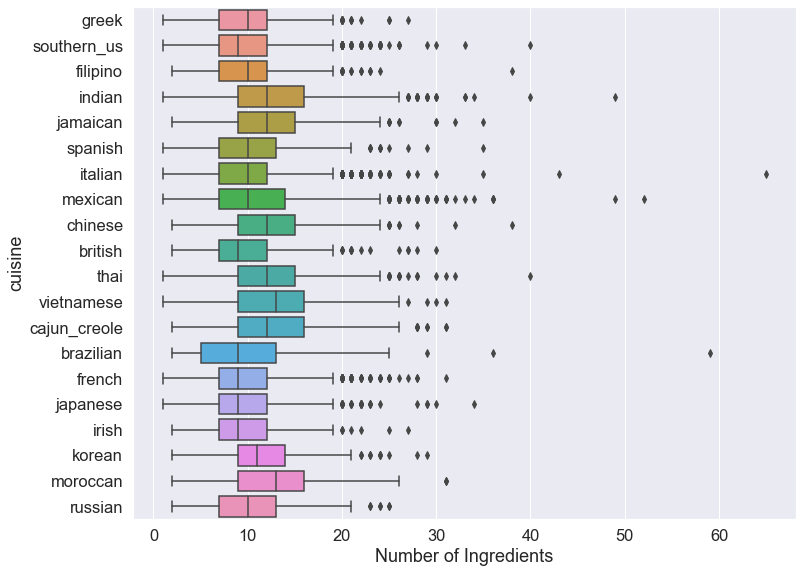

In [10]:
# Create new column for total ingredients in every receipe
train_df["ingr_total"] = train_df.seperated_ingredients.str.split(",").str.len()

# Boxplot
ax = sns.boxplot(x=train_df.ingr_total, y=train_df.cuisine)
ax.set_xlabel("Number of Ingredients")

plt.tight_layout()
plt.show()

### Συχνότερα Υλικά στο Σύνολο Δεδομένων (κορυφαία 20)

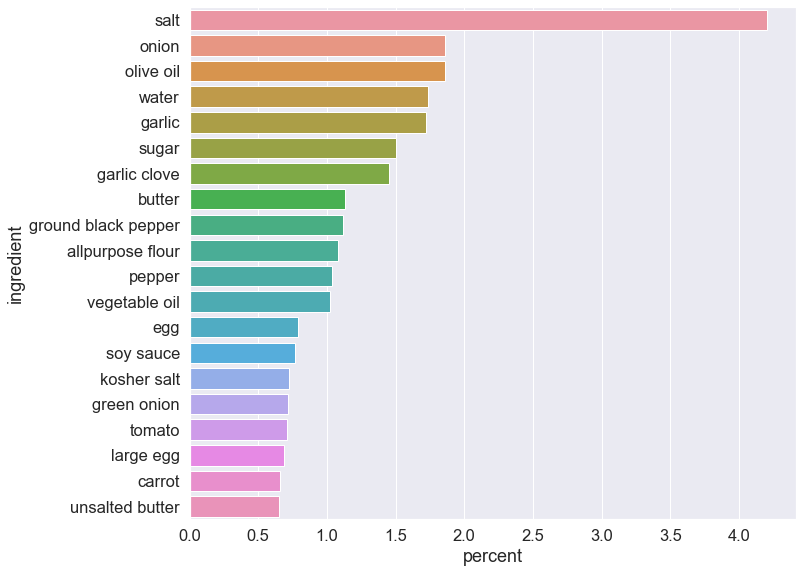

In [11]:
# Expand each ingredient in a new column
df_ = train_df.seperated_ingredients.str.split(",", expand=True)

# Count values for each columns
df_ingr = [df_.iloc[:, i].value_counts() for i in range(df_.shape[1])]

# Merge results of each column
df_ingr = pd.concat(df_ingr).reset_index(name="counts").rename(columns={"index": "ingredient"})

# Merge same ingredients
df_ingr = df_ingr.groupby(["ingredient"], as_index=False).agg("sum")

# Drop first row, as it is badly indexed
df_ingr.drop([0], inplace=True)
df_ingr.sort_values(by="counts", ascending=False, inplace=True)

# 10 Most used
df_ingr["percent"] = (df_ingr.counts / df_ingr.counts.sum()) * 100
sns.barplot(x=df_ingr.percent[:20], y=df_ingr.ingredient[:20])

plt.tight_layout()
plt.show()

### Εξέταση Διάφορων Κουζινών

In [12]:
def cuisine_dish(df, cuisine):
    # Keep requested cuisine
    df_ = df[df.cuisine == cuisine].copy()
    
    # Expand each ingredient in a new column
    df_ = df_.seperated_ingredients.str.split(",", expand=True)
    
    # Count values for each columns
    df_ingr = [df_.iloc[:, i].value_counts() for i in range(df_.shape[1])]
    
    # Merge results of each column
    df_ingr = pd.concat(df_ingr).reset_index(name="counts").rename(columns={"index": "ingredient"})
    
    # Merge same ingredients
    df_ingr = df_ingr.groupby(["ingredient"], as_index=False).agg("sum")
    
    # Drop first row, as it is badly indexed
    df_ingr.drop([0], inplace=True)
    df_ingr.sort_values(by="counts", ascending=False, inplace=True)
    
    # 10 Most used
    df_ingr["percent"] = (df_ingr.counts / df_ingr.counts.sum()) * 100
    ax = vc.plot(kind="pie", y="percent", legend=False, autopct="%1.f%%", labels=df_ingr.ingredient)

    # Remove annoying y label
    ax.set_ylabel("")
    ax.set_title(f"{cuisine} cuisine")
    
    plt.tight_layout()
    plt.show()

### Ελληνική Κουζίνα

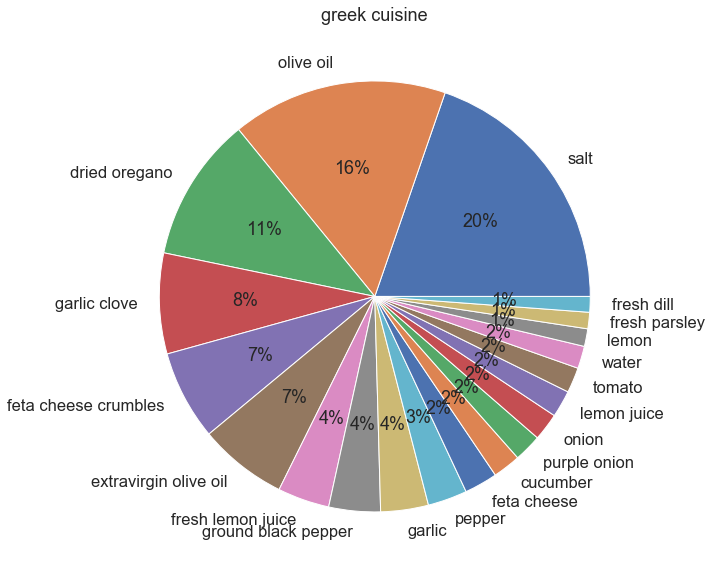

In [13]:
cuisine_dish(train_df, "greek")

### Ινδική Κουζίνα

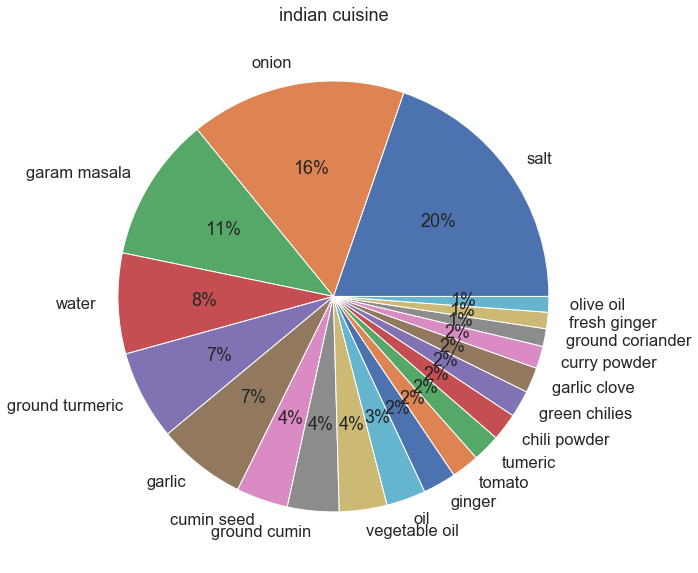

In [14]:
cuisine_dish(train_df, "indian")

### Συχνότερα Bigrams 

In [15]:
def count_bigrams(df, cuisine, top=10):
    # Grab copy of correspoding cusine
    df_ = df[df.cuisine == cuisine].copy()
    
    df_["bigrams"] = df_.seperated_ingredients
    
    # Remove commas
    reg = re.compile(",")
    df_.bigrams.replace(reg, " ", inplace=True)
    df_["bigrams"] = df_.bigrams.str.split(" ")
    
    # Get all possible bigrams for each receipe
    df_["bigrams"] = df_.bigrams.apply(
                  lambda row: [" ".join(row[i: i+2]) for i in range(len(row)-1)])
    
    # Join list of different bigrams into 1 string
    df_["bigrams"] = df_.bigrams.str.join(",")
    
    # Split-expand that string every tuple
    df_ = df_.bigrams.str.split(",", expand=True)
    
    # Count values for each columns
    df_ingr = [df_.iloc[:, i].value_counts() for i in range(df_.shape[1])]
        
    # Merge results of each column
    df_ingr = pd.concat(df_ingr).reset_index(name="counts").rename(columns={"index": "bigram"})
        
    # Merge same ingredients
    df_ingr = df_ingr.groupby(["bigram"], as_index=False).agg("sum")
        
    # Drop first row, as it is badly indexed
    df_ingr.drop([0], inplace=True)
    df_ingr.sort_values(by="counts", ascending=False, inplace=True)
    
    # percent
    df_ingr["percent"] = (df_ingr.counts / df_ingr.counts.sum()) * 100
    
    # Keep current cuisine as column
    df_ingr["cuisine"] = cuisine
    
    return df_ingr.iloc[:top]
    

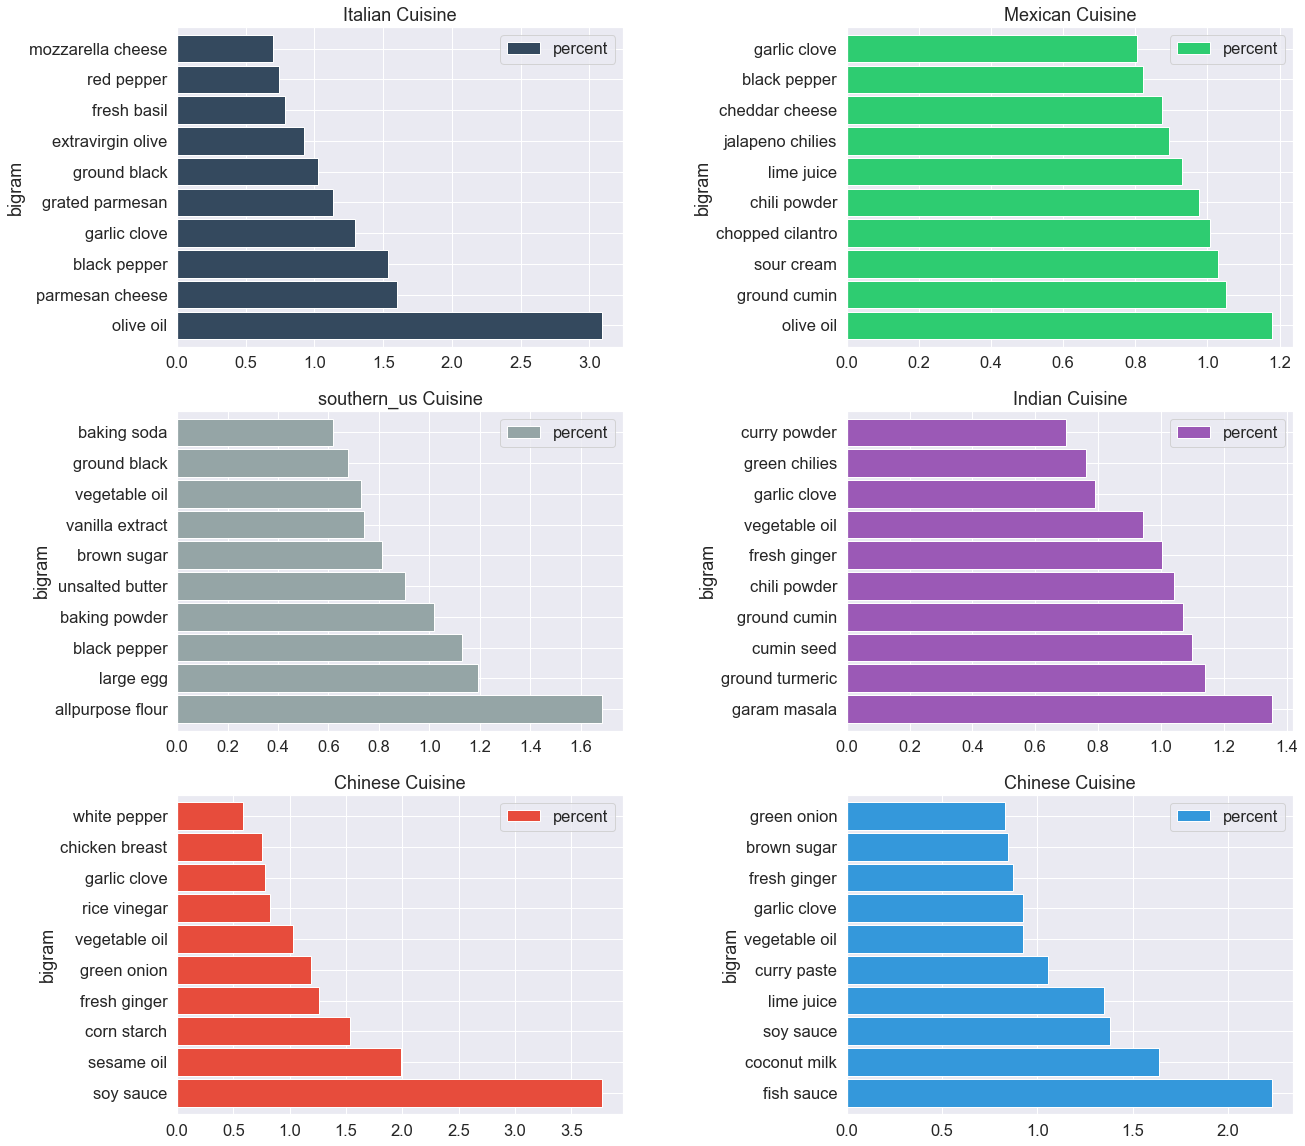

In [16]:
flatui = [ "#34495e", "#2ecc71", "#95a5a6","#9b59b6", "#e74c3c", "#3498db"]

f, ax = plt.subplots(3, 2, figsize=(20,20))

count_bigrams(train_df, "italian")

count_bigrams(train_df, "italian").plot.barh(ax=ax[0,0], x="bigram", y="percent", width=0.9, color= flatui[0])
ax[0,0].set_title("Italian Cuisine")

count_bigrams(train_df, "mexican").plot.barh(ax=ax[0,1], x="bigram", y="percent", width=0.9,color = flatui[1])
ax[0,1].set_title("Mexican Cuisine")

count_bigrams(train_df, "southern_us").plot.barh(ax=ax[1,0], x="bigram", y="percent", width=0.9, color=flatui[2])
ax[1,0].set_title("southern_us Cuisine")

count_bigrams(train_df, "indian").plot.barh(ax=ax[1,1], x="bigram", y="percent", width=0.9, color=flatui[3])
ax[1,1].set_title("Indian Cuisine")

count_bigrams(train_df, "chinese").plot.barh(ax=ax[2,0], x="bigram", y="percent", width=0.9, color=flatui[4])
ax[2,0].set_title("Chinese Cuisine")

count_bigrams(train_df, "thai").plot.barh(ax=ax[2,1], x="bigram", y="percent", width=0.9, color=flatui[5])
ax[2,1].set_title("Chinese Cuisine")

plt.subplots_adjust(wspace=0.5)

## Create Biagrams

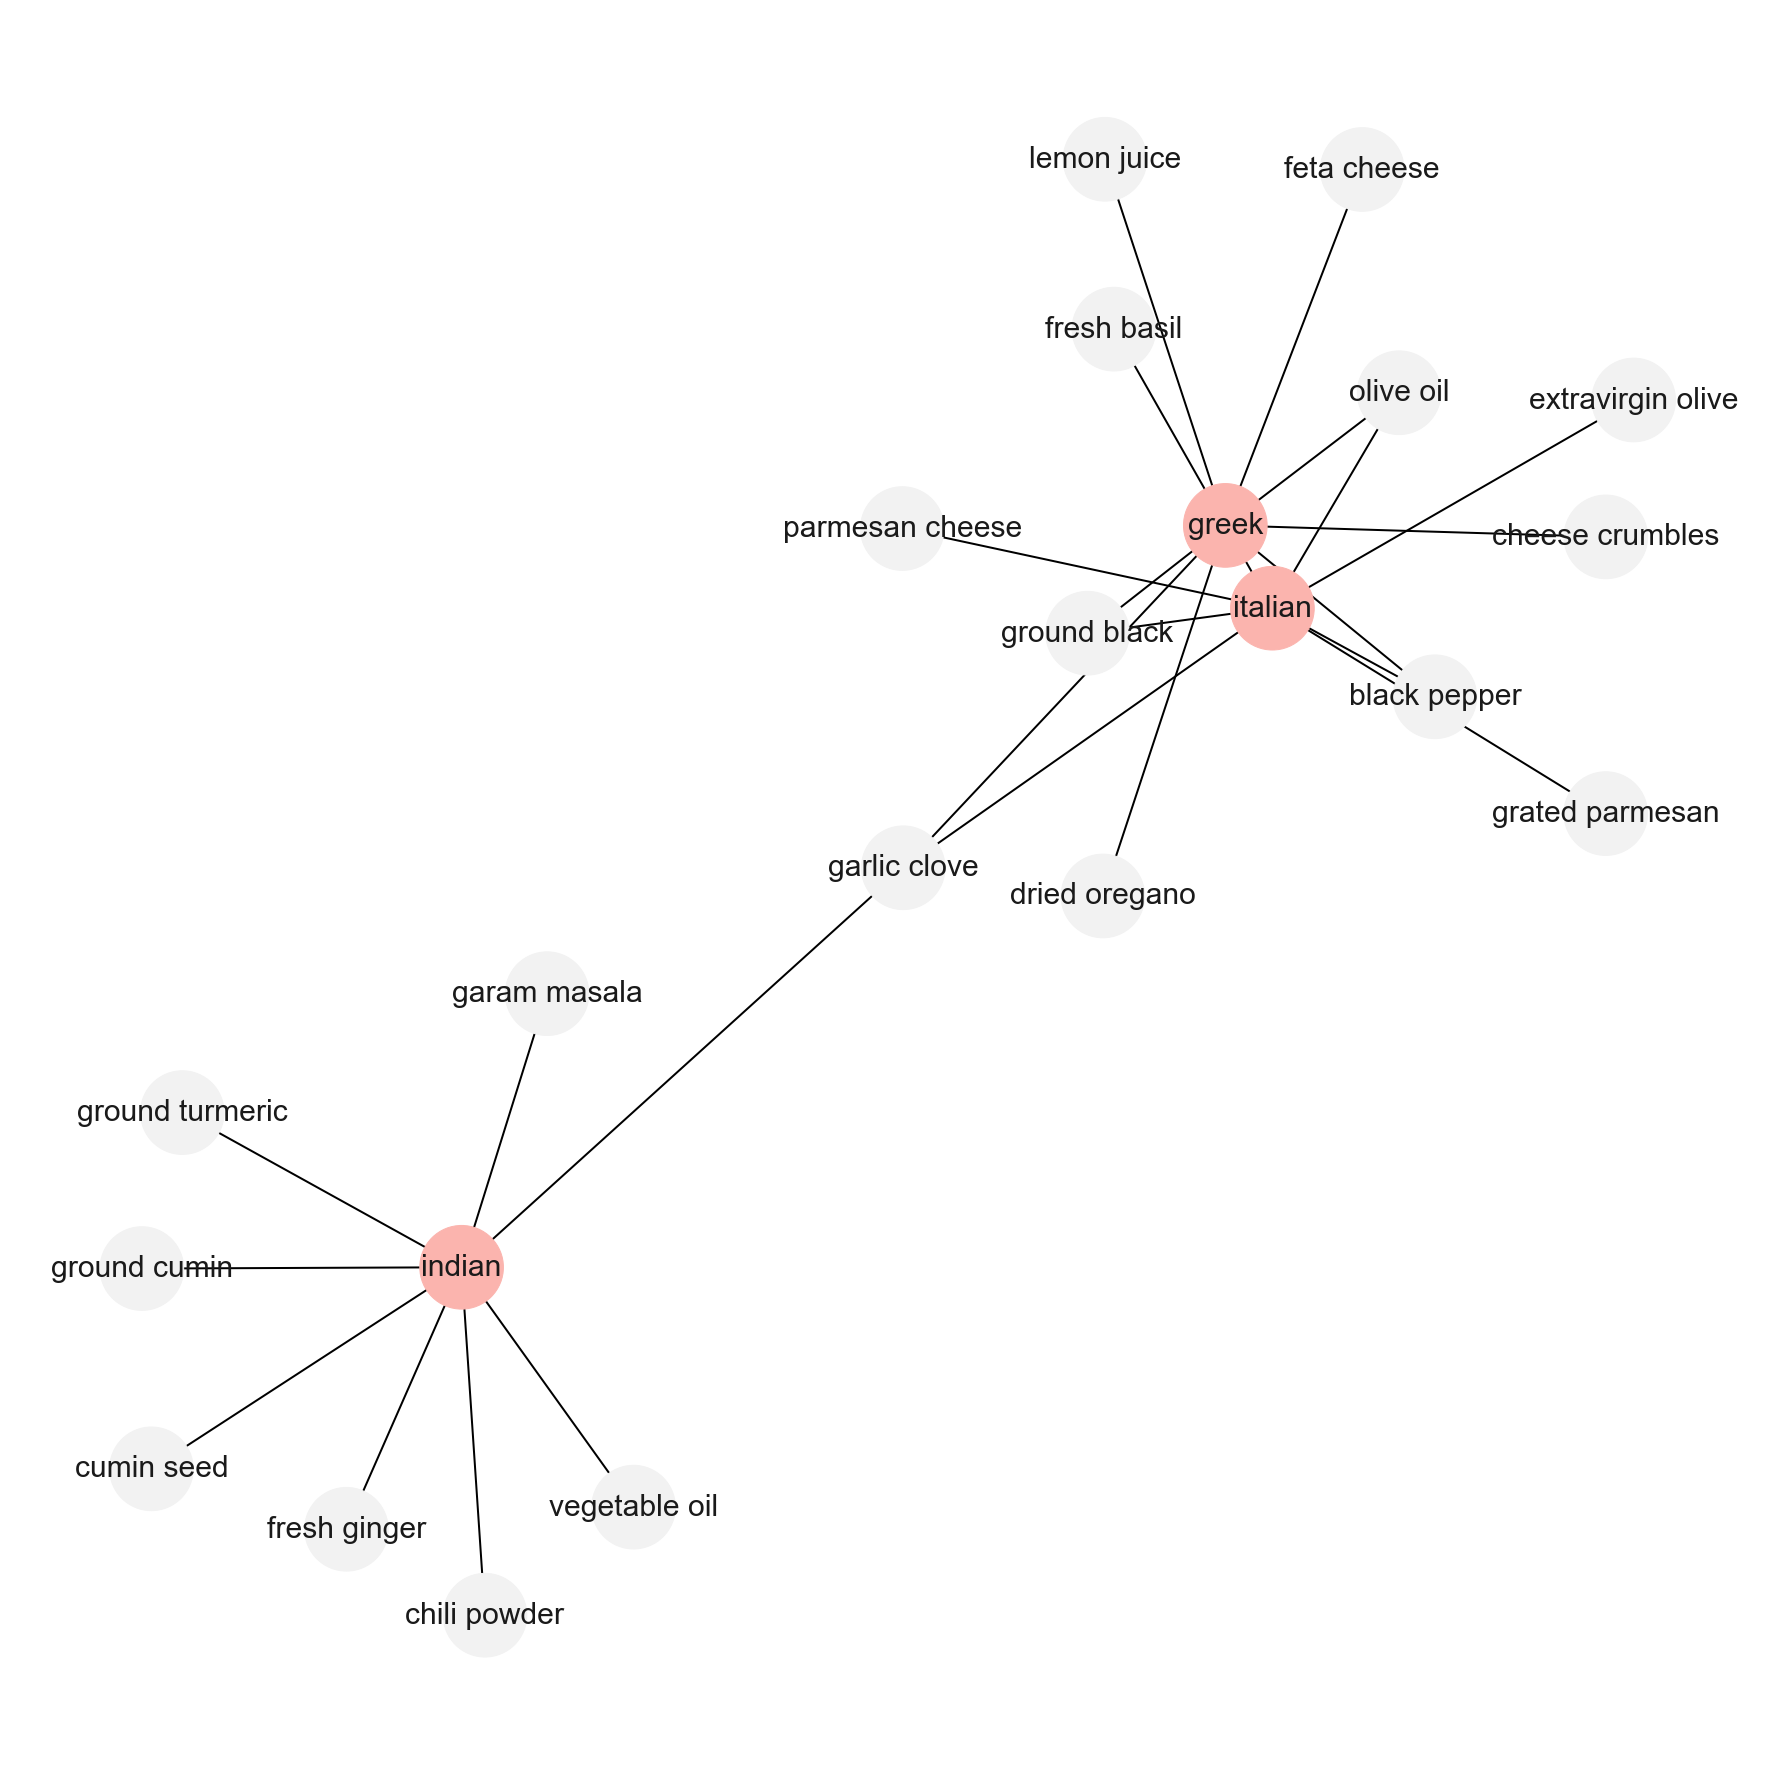

In [20]:
def cuisine_network(df, cuisines):
    
    # Collect nodes here
    nodes = []
    
    for cuisine in cuisines:
        
        # Grab biagram counts for each cuisine
        node = count_bigrams(df, cuisine, top=8)  
        
        nodes.append(node)
        
    # Concat all nodes
    nodes = pd.concat(nodes)
    
    # Build Graph
    g = nx.from_pandas_edgelist(nodes, source="cuisine", target="bigram")
    
    # Same color for cuisines (1), same color for bigrams (5) 
    node_color = [1 if node in cuisines else 5 for node in g.nodes()]
    
    fig, ax = plt.subplots()
    
    # Plot graph
    pos = nx.spring_layout(g, k=0.5)
    nx.draw_networkx(g, pos, with_labels=True, node_size=7000, cmap=plt.cm.Pastel1,
                     edge_color="black", node_color=node_color, font_size=30, width=2)
    
    # Set background to white
    ax.axis('off')
    fig.set_facecolor('white')

    fig.set_size_inches(25, 25)    
    plt.tight_layout()
    plt.show()
    
    
cuisine_network(train_df, ["greek", "italian", "indian"])

## Μηχανική Μάθηση με Αραίους Πίνακες

### Λογιστική Παλινδρόμηση

### Λογιστική Παλινδρόμηση - Ρύθμιση Υπερπαραμέτρων

In [ ]:
pipe1 = Pipeline([('classifier' , LogisticRegression())])

param_grid1 = [
    {"classifier" : [LogisticRegression()],
     "classifier__penalty" : ["l2"],
    "classifier__solver" : ["newton-cg", "sag", "saga", "lbfgs"]},
   ]

# Create grid search object

clf1 = GridSearchCV(pipe, param_grid1 = param_grid1, cv = 5, verbose=True, n_jobs=-1)

# Fit on data

clf1.fit(X_train, y_train)

clf1.best_params_

### Λογιστική Παλινδρόμηση - Αξιολόγηση

In [ ]:
t = time.time()

# -------------------------- Logistic Regression Classifier -----------------------------------------

clf_logreg = LogisticRegression(penalty="l2", solver="newton-cg")
clf_logreg.fit(X_train, y_train)
y_pred_lr = clf_logreg.predict(X_test)

print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_lr)*100:0.2f} %")

elapsed = time.time() - t
print()
print(f"Elapsed: {round(elapsed/60,1)} min")

### Δένδρα Αποφάσεων

### Δένδρα Αποφάσεων - Ρύθμιση Υπερπαραμέτρων

In [ ]:
# Create lists of parameter for Decision Tree Classifier

decisiontree = tree.DecisionTreeClassifier()

pipe = Pipeline(steps=[("decisiontree", decisiontree)])

criterion = ["gini", "entropy"]
max_depth = [200, 250, 300, 350]

parameters = dict(decisiontree__criterion=criterion, decisiontree__max_depth=max_depth)

clf2 = GridSearchCV(pipe, parameters)

# Fit the grid search

clf2.fit(X_train, y_train)

print(clf2.best_params_)

### Δένδρα Αποφάσεων - Αξιολόγηση

In [ ]:
t = time.time()

# ----------------------------- Decision Tree Classifier --------------------------------------------

clf_tree = DecisionTreeClassifier(max_depth=300, criterion="gini")
clf_tree.fit(X_train, y_train)                       
y_pred_dt = clf_tree.predict(X_test)                   

print(f"Decision Tree Accuracy: {accuracy_score(y_test, y_pred_dt)*100:0.2f} %")

elapsed = time.time() - t
print()
print(f"Elapsed: {round(elapsed/60,1)} min")

## Κ-κοντινότερος Γείτονας

### Επιλογή "καλύτερου" γείτονα

In [ ]:
t = time.time()

--------------------------- K-Nearest Neighboor Classifier -------------------


k_range=range(15,31,2)
scores={}
scores_list=[]

for k in k_range:
    clf_knn=KNeighborsClassifier(n_neighbors=k)
    clf_knn.fit(X_train,y_train)
    y_pred_knn=clf_knn.predict(X_test)
    scores_list.append(metrics.accuracy_score(y_test,y_pred_knn))
    

print(f"KNN Accuracy: {max(scores_list)*100:0.2f} %")

fig=plt.subplots(figsize=(28,12))
plt.plot(k_range,scores_list,  marker="o")
plt.xlabel("Value K for KNN", size=22)
plt.ylabel("Testing Accuracy", size=22)
plt.title("K-Neigbour Influence", size=28)
plt.tick_params(axis="both", which="major", labelsize=22)
plt.grid(color="lightgrey")
plt.rcParams['axes.facecolor'] = 'white'

elapsed = time.time() - t
print()
print(f"Elapsed: {round(elapsed/60,1)} min")

### Κ-κοντινότερος Γείτονας - Ρύθμιση Υπερπαραμέτρων

In [ ]:
dist = ["euclidean", "chebyshev", "manhattan"] # metric distance

clf3 = GridSearchCV(KNeighborsClassifier(), dict(n_neighbors=[23], metric=dist), cv=5, scoring='f1_macro', n_jobs=-1)

clf3.fit(X_train, y_train)

print(clf3.best_params_)

In [ ]:
print(clf3.best_params_)

### Αποθήκευση καλύτερου γείτονα

In [ ]:
t = time.time()

# --------------------------- K-Nearest Neighboor Classifier -------------------

clf_knn=KNeighborsClassifier(n_neighbors=23, metric="euclidean")
clf_knn.fit(X_train,y_train)
y_pred_knn=clf_knn.predict(X_test)

print(f"K-Nearest Neighbor Accuracy: {accuracy_score(y_test, y_pred_knn)*100:0.2f} %")

elapsed = time.time() - t
print()
print(f"Elapsed: {round(elapsed/60,1)} min")

## Τυχαία Δάση

### Τυχαία Δάση - Ρύθμιση Υπερπαραμέτρων

In [ ]:
forest = RandomForestClassifier(random_state = 1)

param_grid = { 
    'n_estimators': [100, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [300],
    'criterion' :['gini', 'entropy']
}

clf4 = GridSearchCV(forest, param_grid=param_grid, cv = 5, n_jobs = -1)

clf4.fit(X_train, y_train)

clf4.best_params_

### Τυχαία Δάση - Αξιολόγηση

In [ ]:
t = time.time()

#  --------------------- Random Forest Classifier -------------------------------

rlf = RandomForestClassifier(n_estimators=100, max_features="auto",random_state=0)
rlf.fit(X_train, y_train)
y_pred_rlf = rlf.predict(X_test)

print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rlf)*100:0.2f} %")

elapsed = time.time() - t
print()
print(f"Elapsed: {round(elapsed/60,1)} min")

## Boosting Classifier

In [ ]:
# -------------------------  GradientBoosting Classifier -----------------------------

from sklearn.ensemble import GradientBoostingClassifier

t = time.time()

grbo = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, 
                                  random_state=0, loss='deviance').fit(X_train, y_train)

grbo.fit(X_train, y_train)
y_pred_grbo=grbo.predict(X_test)

print(f"Adaboost Classifier Accuracy:{accuracy_score(y_test, y_pred_grbo)*100:0.2f} %")

elapsed = time.time() - t
print()
print(f"Elapsed: {round(elapsed/60,1)} min")


# ------------------------------------------------------------------------------


# # -------------------------  Adaboost Classifier -----------------------------

# from sklearn.ensemble import AdaBoostClassifier

# t = time.time()

# clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
# clf_ada.fit(X_train, y_train)
# y_pred_ada=clf_ada.predict(X_test)

# print("Adaboost Classifier Accuracy (in %) : {0:0.2f}" .format(accuracy_score(y_test, y_pred_ada)*100))

# elapsed = time.time() - t
# print()
# print("Χρόνος Εκτέλεσης Προγράμματος: {} min".format(round(elapsed/60,1)))

## Multinomial Naive Bayes


### Hyperparameter tuning -  MNB

In [ ]:
pipe = Pipeline([('clf', MultinomialNB())])

grid_params = {'clf__alpha': [1, 1e-1, 1e-2, 0]}

clf5 = GridSearchCV(pipe, grid_params, cv=5)

clf5.fit(X_train, y_train)

clf5.best_params_

### MNB - Assessment

In [ ]:
t = time.time()

#  ------------------- Multinomial Naive Bayes Classifier ----------------------

from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB(alpha=0.01)
mnb.fit(X_train,y_train)
y_pred_mnb = mnb.predict(X_test)

print(f"Multinomial Naive Bayes Accuracy: {accuracy_score(y_test,y_pred_mnb)*100:0.2f} %")

elapsed = time.time() - t
print()
print(f"Elapsed: {round(elapsed/60,1)} min")

## Kernel SVM (RBF)

In [ ]:
t = time.time()

#  ------------------- Kernel SVM (RBF) Classifier -----------------

svclassifier = SVC(kernel="rbf")
svclassifier.fit(X_train, y_train)
y_pred_svm = svclassifier.predict(X_test)

print(classification_report(y_test,y_pred_svm))

elapsed = time.time() - t
print()
print(f"Elapsed: {round(elapsed/60,1)} min")

## Precision, Recall and F1 score - All methods

In [ ]:
print("Logistic Regression metrics:", precision_recall_fscore_support(y_test,y_pred_lr, average="macro")[0:3])
print("\nDecision Tree metrics:",precision_recall_fscore_support(y_test,y_pred_dt, average="macro")[0:3])
print("\nK-Nearest Neighbor metrics:",precision_recall_fscore_support(y_test,y_pred_knn, average="macro")[0:3])
print("\nMultinomial Naive Bayes metrics:",precision_recall_fscore_support(y_test,y_pred_mnb, average="macro")[0:3])
print("\nRandom Forest metrics:",precision_recall_fscore_support(y_test,y_pred_rlf, average="macro")[0:3])
print("\nKernel SVM metrics:",precision_recall_fscore_support(y_test,y_pred_svm, average="macro")[0:3])

## ROC Curves

## Create Function for Micro Average ROC Curves

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

def roc(y_test, y_pred):

    n_classes=20
    y_test = label_binarize(y_test, classes=[i for i in range(n_classes)])
    y_pred = label_binarize(y_pred, classes=[i for i in range(n_classes)])

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()

    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    return fpr["micro"], tpr["micro"], roc_auc["micro"]

## Plot ROC Curves for each method

In [ ]:
fpr_lr, tpr_lr, roc_auc_lr=roc(y_test, y_pred_lr)
fpr_dt, tpr_dt, roc_auc_dt=roc(y_test, y_pred_dt)
fpr_knn, tpr_knn, roc_auc_knn=roc(y_test, y_pred_knn)
fpr_rlf, tpr_rlf, roc_auc_rlf=roc(y_test, y_pred_rlf)
fpr_svm, tpr_svm, roc_auc_svm=roc(y_test, y_pred_svm)
fpr_mnb, tpr_mnb, roc_auc_mnb=roc(y_test, y_pred_mnb)


# Plot all ROC curves

fig, (ax1,ax2)=plt.subplots(1,2, figsize=(28,12))
ax1.plot(fpr_knn, tpr_knn, label="Multinomial NB (AUC = {0:0.2f})".format(roc_auc_mnb), linewidth=2)
ax1.plot(fpr_knn, tpr_knn, label="K-Nearest Neighbor (AUC = {0:0.2f})".format(roc_auc_knn), linewidth=2)
ax1.plot(fpr_lr, tpr_lr, label="Logistic Regression (AUC = {0:0.2f})".format(roc_auc_lr), linewidth=2)
ax1.plot(fpr_svm, tpr_svm, label="Kernel SVM (AUC = {0:0.2f})".format(roc_auc_svm), linewidth=2)
ax1.plot(fpr_dt, tpr_dt, label="Decision Tree (AUC = {0:0.2f})".format(roc_auc_dt), linewidth=2)
ax1.plot(fpr_rlf, tpr_rlf, label="Random Forest (AUC = {0:0.2f})".format(roc_auc_rlf), linewidth=2)

# 
ax1.plot([0, 1], [0, 1], "k--", lw=2)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel("False Positive Rate", size=24)
ax1.set_ylabel("True Positive Rate", size=24)
ax1.set_title("ROC Curves - Micro Average", size=27)
ax1.legend(loc="lower right", prop={"size": 20})
ax1.tick_params(axis="both", which="major", labelsize=22)
ax1.grid(color="lightgrey")

AUC=[roc_auc_mnb, roc_auc_knn, roc_auc_lr, roc_auc_svm, roc_auc_dt, roc_auc_rlf]    
bars = ["Multinomial NB", "KNN", "Logistic",  "SVM" , "Decision Tree",  "Random Forest"] 
y_pos = np.arange(len(bars), 2)
 
# Create bars

ax2.bar(bars, AUC, color="darkblue")
ax2.set_ylim([0.6, 1.05])
ax2.set_xlabel("Methods", size=24)
ax2.set_ylabel("AUC", size=24)
ax2.set_title("AUC Comparison", size=27)
ax2.tick_params(axis="both", which="major", labelsize=22)
ax2.grid(color="lightgrey")
ax2.xaxis.set_tick_params(rotation=-15)

# Show graphic

plt.show()
plt.rcParams['axes.facecolor'] = 'white'



## Voting Classifier

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import VotingClassifier

t = time.time()

vot=VotingClassifier(estimators=[("Logistic",clf_logreg),("SVM",CalibratedClassifierCV(svclassifier)),  
                        ("KNN",KNeighborsClassifier(n_neighbors=25)) ], voting="soft", weights=[3,15,2])

vot.fit(X_train,y_train)
y_pred_vot=vot.predict(X_test)

print(f"Soft VotingClassifier Accuracy : {accuracy_score(y_test, y_pred_vot)*100:0.2f} %.")


elapsed = time.time() - t
print()
print(f"Elapsed: {round(elapsed/60,1)} min")

# Dimensionality Reduction

## Estimate Covariance Matrix

In [ ]:
covariance_matrix=np.cov(X_train.todense().transpose())

print("Διάσταση πίνακα συνδιασπορών :", np.shape(covariance_matrix))

U, s, V = np.linalg.svd(covariance_matrix)

x=range(1,len(s)+1)
y=np.cumsum(s)

## Infuence of Principal Components

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,7))

ax1.scatter(np.array(range(1,len(s)+1)), np.log(s/np.sum(s)))
ax1.set_ylim(-16,-3)
ax1.set_ylabel("Log-Fraction of Variance per Component", size=15)
ax1.set_xlabel("Number of components", size=15)
ax1.set_title("Fraction of Total Variance Explained per each Principal Component", size=17)
ax1.tick_params(axis="both", which="major", labelsize=13)
ax1.grid(color='lightgrey')
plt.rcParams['axes.facecolor'] = 'white'

ax2.scatter(x,y)
ax2.set_xlabel("Number of components", size=15) 
ax2.set_ylabel("Cumulative Variance (%)", size=15) 
ax2.set_title("Cumulative Variance Explained Explained from Principal Components", size=17) 
ax2.tick_params(axis="both", which="major", labelsize=13)
# plt.rcParams["axes.facecolor"] = "white"
ax2.tick_params(axis="both", which="major", labelsize=13)

ax2.grid(color="lightgrey")
plt.rcParams['axes.facecolor'] = 'white'

## Save Predictions of Each Method for different Components

In [ ]:
features=[250,500,750,1150]

var=[]
acc_lr, list_pred_lr = [], []
acc_dt, list_pred_dt = [], []
acc_knn,list_pred_knn = [], []
acc_rlf, list_pred_rlf = [], []
acc_svm, list_pred_svm = [], []

for i in features:
    
    pca= PCA(n_components=i)

    pca.fit(X_train.todense())

    # Προβολή των train και test δεδομένων στους αξονες

    X_train_pca=pca.transform(X_train.todense())
    X_test_pca=pca.transform(X_test.todense())
        
    var.append(sum(pca.explained_variance_ratio_)*100)
     
    
    # -------------------------- Logistic Regression Classifier -----------------------------------------

    clf_logreg.fit(X_train_pca, y_train)
    y_pred_lr_pca = clf_logreg.predict(X_test_pca)
    
    acc_lr.append(accuracy_score(y_test, y_pred_lr_pca)*100)
    list_pred_lr.append(y_pred_lr_pca)
    print("logistic")
    
    
    # ----------------------------- Decision Tree Classifier --------------------------------------------

    clf_tree.fit(X_train_pca, y_train)                       
    y_pred_dt_pca = clf_tree.predict(X_test_pca)                   

    acc_dt.append(accuracy_score(y_test, y_pred_dt_pca)*100)     
    list_pred_dt.append(y_pred_dt_pca)
    print("tree")
    
     # --------------------------- K-Nearest Neighboor Classifier -------------------

    clf_knn.fit(X_train_pca,y_train)
    y_pred_knn_pca=clf_knn.predict(X_test_pca)

    acc_knn.append(accuracy_score(y_test, y_pred_knn_pca))
    list_pred_knn.append(y_pred_knn_pca)
    print("k-NN")
    
    #  --------------------- Random Forest Classifier -------------------------------

    rlf.fit(X_train_pca, y_train)
    y_pred_rlf_pca = rlf.predict(X_test_pca)
    
    acc_rlf.append(accuracy_score(y_test, y_pred_rlf_pca))
    list_pred_rlf.append(y_pred_rlf_pca)
    print("forest")

    
with open("list_lr.txt", "wb") as fp_lr:   
    pickle.dump(list_pred_lr , fp_lr) 
    

with open("list_dt.txt", "wb") as fp_dt:  
    pickle.dump(list_pred_dt , fp_dt) 
    


with open("list_knn.txt", "wb") as fp_knn:   
    pickle.dump(list_pred_knn , fp_knn) 


with open("list_rlf.txt", "wb") as fp_rlf:  
    pickle.dump(list_pred_rlf , fp_rlf) 

## Load Predictions of Each Method for different Components

In [ ]:
with open("list_lr.txt", "rb") as list_lr:  
    list_pred_lr = pickle.load(list_lr)

with open("list_knn.txt", "rb") as list_knn:   
    list_pred_knn = pickle.load(list_knn)
    
with open("list_dt.txt", "rb") as list_dt:   
    list_pred_dt = pickle.load(list_dt)
    
with open("list_rlf.txt", "rb") as list_rlf:   
    list_pred_rlf = pickle.load(list_rlf)

## Assessment of Each Method for different Components

In [ ]:
features=[250,500,750,1150]


# Plot all ROC curves

fig, ax =plt.subplots(2,2, figsize=(28,18))

for i in range(len(list_pred_lr)):
    
    ind1, ind2=0,0
    fpr_pca_lr, tpr_pca_lr, roc_auc_pca_lr=roc(y_test, list_pred_lr[i])
    ax[0,0].plot(fpr_pca_lr, tpr_pca_lr, label="Features = {}, AUC= {:.2f}".format(features[i], roc_auc_pca_lr), linewidth=2)


    fpr_pca_dt, tpr_pca_dt, roc_auc_pca_dt=roc(y_test, list_pred_dt[i])
    ax[0,1].plot(fpr_pca_dt, tpr_pca_dt, label="Features = {}, AUC= {:.2f}".format(features[i], roc_auc_pca_dt), linewidth=2)
    
    fpr_pca_knn, tpr_pca_knn, roc_auc_pca_knn=roc(y_test, list_pred_knn[i])
    ax[1,0].plot(fpr_pca_knn, tpr_pca_knn,label="Features = {}, AUC= {:.2f}".format(features[i], roc_auc_pca_knn), linewidth=2)

    fpr_pca_rlf, tpr_pca_rlf, roc_auc_pca_rlf=roc(y_test, list_pred_rlf[i])
    ax[1,1].plot(fpr_pca_rlf, tpr_pca_rlf, label="Features = {}, AUC= {:.2f}".format(features[i], roc_auc_pca_rlf), linewidth=2)


methods = ["Logistic Regression", "Decision Tree", "KNN", "Random Forest"]

ind=0

for ax in ax.flat:

    ax.plot([0, 1], [0, 1], "k--", lw=2)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("False Positive Rate", size=24)
    ax.set_ylabel("True Positive Rate", size=24)
    ax.legend(loc="lower right", prop={"size": 20})
    ax.set_title("ROC Curves - {}".format(methods[ind]), size=27)
    ax.tick_params(axis="both", which="major", labelsize=22)
    ax.grid(color="lightgrey")
    ind+=1

plt.subplots_adjust( hspace=0.3)

# Show graphic

plt.show()
